### Path Structure 

In [1]:
!tree -L 2

.
├── data
│   ├── 2404_1024x1024_3.png
│   ├── warplane.jpg
│   ├── warplane2.jpg
│   └── warplane3.jpg
├── fgsm_adversarial_attack.ipynb
├── public_release
│   ├── multires
│   ├── multires.pb
│   ├── multires_aug
│   ├── multires_aug.pb
│   ├── test_images
│   ├── vanilla
│   ├── vanilla.pb
│   ├── xview.pbtxt
│   └── xview_complete_list.pbtxt
└── xview_multires_detector.ipynb

6 directories, 11 files


In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

from object_detection.utils import ops as utils_ops
if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
    raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

import matplotlib.pyplot as plt
%matplotlib inline

import sys
site_packages = next(p for p in sys.path if 'site-packages' in p)

### Crop and prep the large tiffs for Object detection

In [2]:
def crop(infile,height,width):
    im = Image.open(infile)
    imgwidth, imgheight = im.size
    for i in range(imgheight//height):
        for j in range(imgwidth//width):
            box = (j*width, i*height, (j+1)*width, (i+1)*height)
            yield im.crop(box)

img_name = 1235
infile = os.path.join('./public_release/test_images/%s.tif' %img_name)
height = 1024
width = 1024
start_num=1
for k,piece in enumerate(crop(infile,height,width),start_num):
    img=Image.new('RGB', (height,width), 255)
    img.paste(piece)
    cropped_image=os.path.join('./public_release/test_images/',"%s_%sx%s_%s.png" % (img_name, height, width, k))
    img.save(cropped_image)

In [3]:

PATH_TO_FROZEN_GRAPH = './public_release/multires.pb'
PATH_TO_LABELS = os.path.join('./public_release/xview.pbtxt')


detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()

        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)


In [4]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    if image.mode =='RGBA':
        image = image.convert('RGB')
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)


In [5]:
def object_detector(image_name):
    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            for item in dirs:
                if item.endswith(image_name):
                    image = Image.open(input_path + item)
                    f, e = os.path.splitext(input_path + item)
                    image_np = load_image_into_numpy_array(image)
                    image_np_expanded = np.expand_dims(image_np, axis=0)

                    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
                    boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
                    scores = detection_graph.get_tensor_by_name('detection_scores:0')
                    classes = detection_graph.get_tensor_by_name('detection_classes:0')
                    num_detections = detection_graph.get_tensor_by_name('num_detections:0')

                    (boxes, scores, classes, num_detections) = sess.run([boxes,
                                                                         scores,
                                                                         classes,
                                                                         num_detections],
                                                                        feed_dict={image_tensor: image_np_expanded})
                    return boxes, scores, classes, num_detections

In [6]:
#!ls data

In [7]:

input_path = os.path.join('./data/')
output_path= os.path.join('./misc/cropped/')
dirs = os.listdir(input_path)


test_image_name = "2404_1024x1024_3.png"

image_src = Image.open(input_path+test_image_name)
image_np = np.array(image_src)


In [8]:

boxes, scores, classes, num_detections = object_detector(test_image_name)


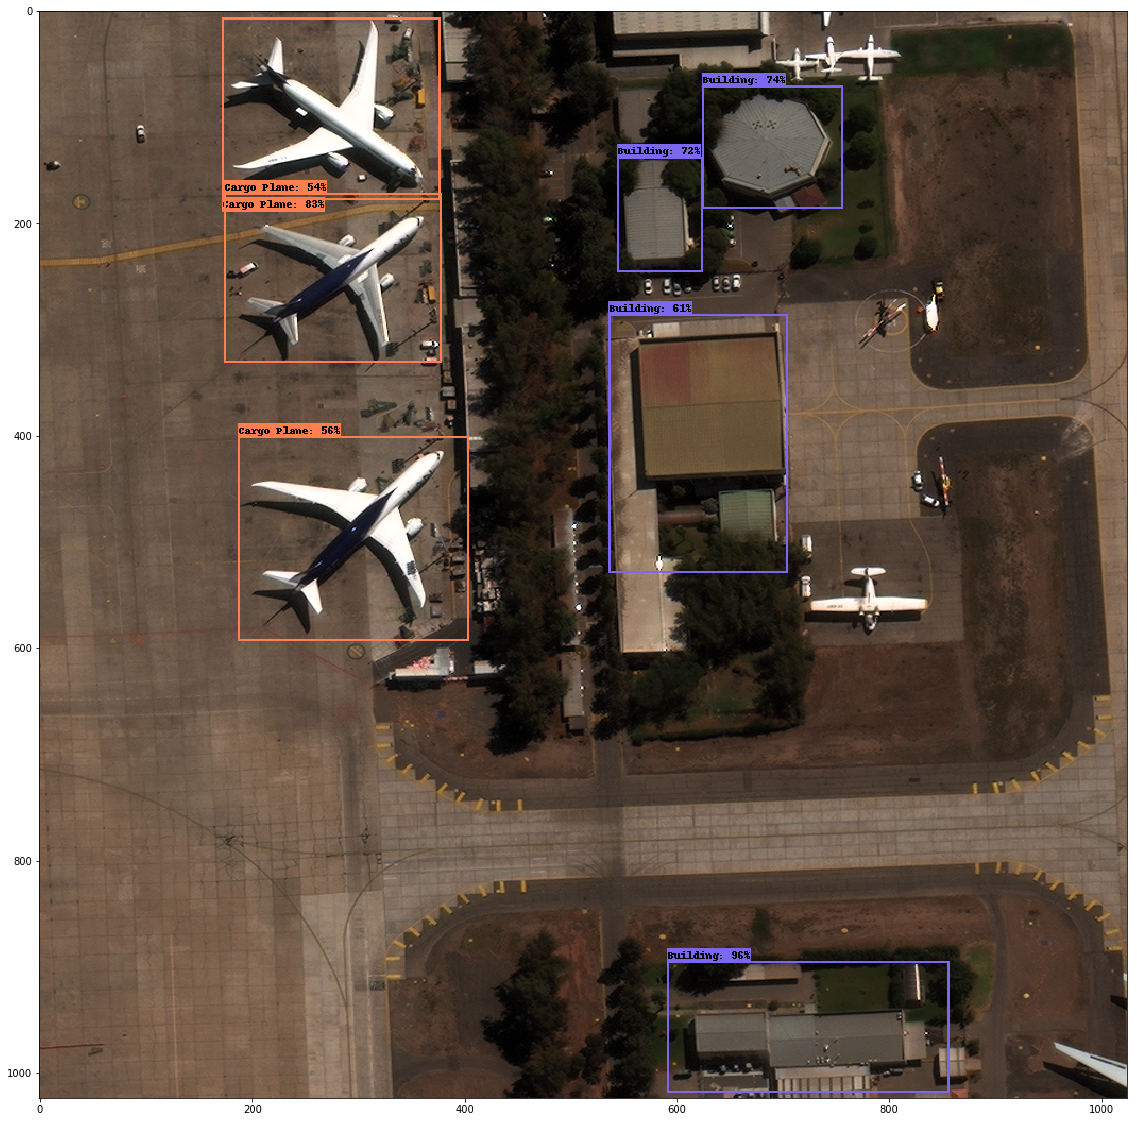

In [9]:
plt.figure(figsize=(20,20))
vis_util.visualize_boxes_and_labels_on_image_array(
                        image_np,
                        np.squeeze(boxes),
                        np.squeeze(classes).astype(np.int32),
                        np.squeeze(scores),
                        category_index,
                        use_normalized_coordinates=True,
                        line_thickness=2)
img = Image.fromarray(image_np, 'RGB')
plt.imshow(image_np)
plt.show()


### Select, crop and save detected object

In [11]:

all_boxes = np.squeeze(boxes)
all_scores = np.squeeze(scores),
max_boxes_to_draw = all_boxes.shape[0]
h, w, b = image_np.shape
min_score_thresh = 0.5
image_np = np.array(image_src)
filename_base, file_extension = os.path.splitext(input_path+test_image_name)
_, output_dir = os.path.split(filename_base)
output_filename_base = output_path+output_dir

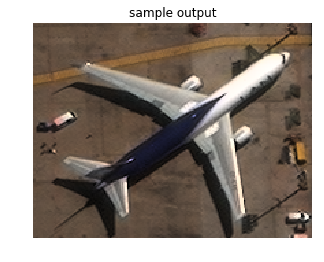

In [13]:
image_np = np.array(image_src)
all_classes = np.squeeze(classes).astype(np.int32)
selected_class = 13
fig=plt.figure(figsize=(5, 5))


for i in range(min(max_boxes_to_draw, all_boxes.shape[0])):

    if  all_scores[0][i] > min_score_thresh:
        selected_classes = all_classes[i]
        if selected_classes ==selected_class:
            bob = tuple(all_boxes[i].tolist())

            ymin, xmin, ymax, xmax = bob

            (left, right, top, bottom) = (xmin * w, xmax * w, ymin * h, ymax * h)
            output_filename_n = "{}_{}{}".format(output_filename_base, i, file_extension)
            bb = np.zeros(4, dtype=np.uint32)

            bb[0] = np.maximum(left , 0)
            bb[1] = np.maximum(top, 0)
            bb[2] = np.minimum(right , h)
            bb[3] = np.minimum(bottom, w)
            images_stack = []
            cropped = image_np[bb[1]:bb[3],bb[0]:bb[2],:]
    
            try:
                plt.imshow(cropped)
                plt.title('sample output')
                plt.axis('off')
                
                cropped_img = Image.fromarray(cropped)
                scaled = cropped_img.resize((256,256), Image.ANTIALIAS)
                scaled.save(output_filename_n, "JPEG")
            except:
                pass


In [301]:

# for i in range(min(max_boxes_to_draw, all_boxes.shape[0])):
#     if  all_scores[0][i] > min_score_thresh:

#         bob = tuple(all_boxes[i].tolist())

#         ymin, xmin, ymax, xmax = bob
    
#         (left, right, top, bottom) = (xmin * w, xmax * w, ymin * h, ymax * h)
#         output_filename_n = "{}_{}{}".format(output_filename_base, i, file_extension)
#         bb = np.zeros(4, dtype=np.uint32)
        
#         bb[0] = np.maximum(left , 0)
#         bb[1] = np.maximum(top, 0)
#         bb[2] = np.minimum(right , h)
#         bb[3] = np.minimum(bottom, w)
    
#         cropped = image_np[bb[1]:bb[3],bb[0]:bb[2],:]
       
#         try:
#             plt.imshow(cropped)
#             cropped_img = Image.fromarray(cropped)
#             scaled = cropped_img.resize((256,256), Image.ANTIALIAS)
#             scaled.save(output_filename_n, "JPEG")
#         except:
#             pass
    